# COVID-19 Mitigation Measures Collateral Damage Assesment 

In this project i will determine which factors are most relevant for the reprodduction of the SARS-CoV2 virus in Austria, built a SIR-based model to simulate various scenarios for different stringency of mitigation measures and then try to estimate the collateral damage by said measures. End product is an estimate for collateral damage of measures and effectiveness in containing the virus

In [77]:
import os
import requests
from pprint import pprint
import covsirphy as cs
import pandas as pd
import numpy as np
import datetime
from operator import add

import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import ttest_ind
from scipy import signal

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7*0.5,10.27*0.5)})

In [78]:
# Some Sources:
# https://www.who.int/bulletin/online_first/BLT.20.265892.pdf
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7333368/

## 1. Data Preparation and Exploration

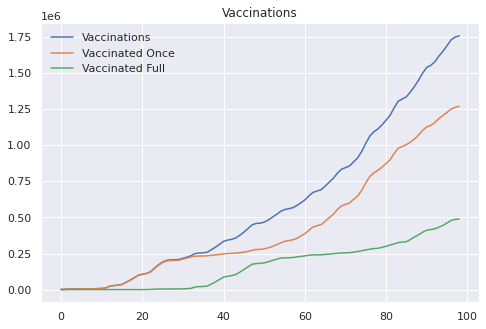

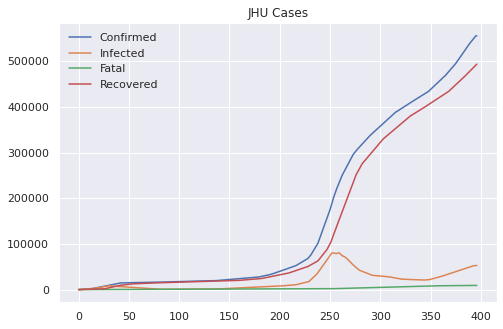

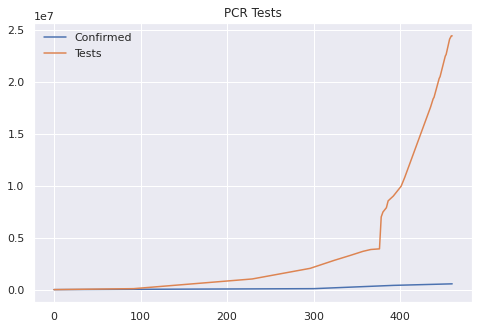

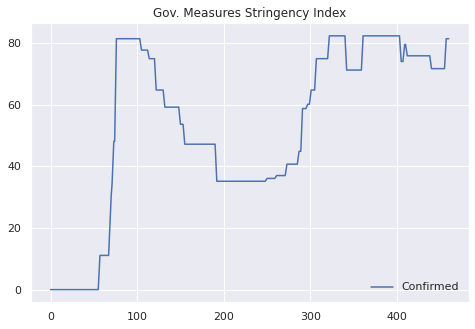

In [79]:
#Get data
data_loader = cs.DataLoader("../input")
jhu_data = data_loader.jhu() #Cases (JHU)
population_data = data_loader.population() # Population
oxcgrt_data = data_loader.oxcgrt() # Government Response (OxCGRT)
pcr_data = data_loader.pcr() # Tests
vaccine_data = data_loader.vaccine() # Vaccinations
#print(vaccine_data.subset("Austria"))
plt.plot(vaccine_data.subset("Austria")['Vaccinations'], label='Vaccinations')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_once'], label='Vaccinated Once')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_full'], label='Vaccinated Full')
plt.title('Vaccinations')
plt.legend()
plt.show()

#print(jhu_data.subset("Austria"))
plt.plot(jhu_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(jhu_data.subset("Austria")['Infected'], label='Infected')
plt.plot(jhu_data.subset("Austria")['Fatal'], label='Fatal')
plt.plot(jhu_data.subset("Austria")['Recovered'], label='Recovered')
plt.title('JHU Cases')
plt.legend()
plt.show()

#print(pcr_data.subset("Austria"))
plt.plot(pcr_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(pcr_data.subset("Austria")['Tests'], label='Tests')
plt.title('PCR Tests')
plt.legend()
plt.show()

#print(oxcgrt_data.subset("Austria"))
plt.plot(oxcgrt_data.subset("Austria")['Stringency_index'], label='Confirmed')
plt.title('Gov. Measures Stringency Index')
plt.legend()
plt.show()

country = "Austria"
aut_cov = jhu_data.subset("Austria")
aut_pop = population_data.subset("Austria")
aut_gov = oxcgrt_data.subset("Austria")
aut_pcr = pcr_data.subset("Austria")
aut_vac = vaccine_data.subset("Austria") 

age 0 to 9
age 10 to 19
age 20 to 29
age 30 to 39
age 40 to 49
age 50 to 59
age 60 to 69
age 70 to 79
age 80 to 89
age 90 to 99
age 100 to 109
8901064


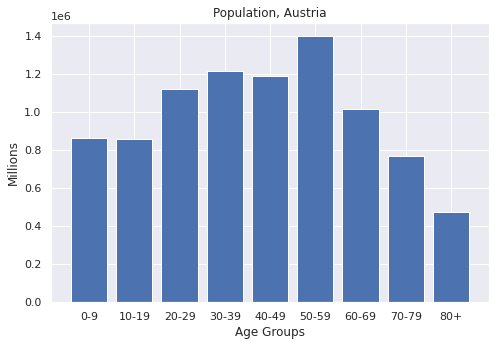

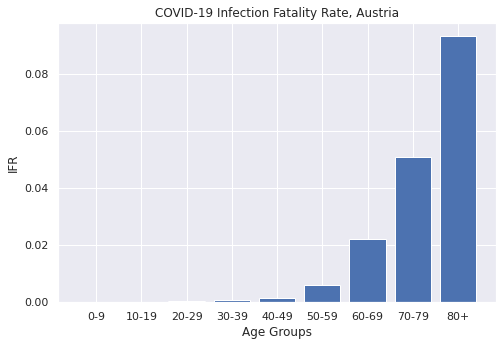

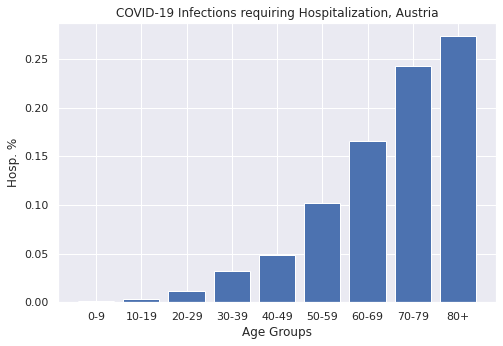

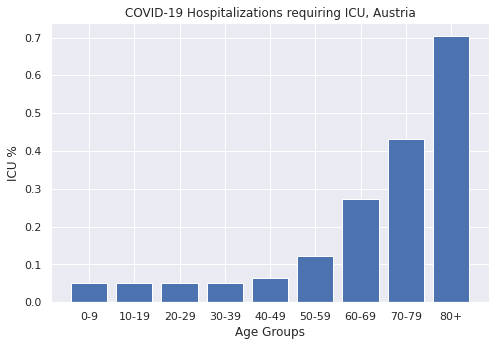

In [80]:
# Population
# https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/bevoelkerungsstruktur/bevoelkerung_nach_alter_geschlecht/index.html
dfs = pd.read_excel("bevoelkerung_am_1.1.2020_nach_alter_und_bundesland_-_insgesamt.xlsx", sheet_name=None)
dfs = dfs['Insgesamt'][['Bevölkerung am 1.1.2020 nach Alter und Bundesland - Insgesamt', 'Unnamed: 1']].loc[4:104]
dfs = dfs.reset_index(drop=True)

pop_groups = []
for i in range(0,104,10):
    print('age',i,'to',i+9)
    pop_groups.append(dfs['Unnamed: 1'].loc[i:i+9].sum())

pp80 = sum(pop_groups[-3:])
pop_groups = pop_groups[:-3]
pop_groups.append(pp80)
assert(sum(pop_groups)==dfs['Unnamed: 1'].sum())
print(sum(pop_groups))
# Source:
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
pop_groups_ifr = [0.00002, 0.00006, 0.0003, 0.0008, 0.0015, 0.006, 0.022, 0.051, 0.093]
pop_groups_hosp = [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]
pop_groups_hosp_icu = [0.05, 0.05, 0.05, 0.05, 0.063, 0.122, 0.274, 0.432, 0.703]

#print(pop_groups)
#print(pop_groups_ifr)
#print(pop_groups_hosp)
#print(pop_groups_hosp_icu)

x = np.linspace(0, len(pop_groups), len(pop_groups), endpoint=False, dtype=int)
groups_labels = ["{}-{}".format(i, i+9) for i in range(0,90,10)][:-1]+['80+']
plt.xlabel('Age Groups')
plt.ylabel('Millions')
plt.title('Population, Austria')
plt.bar(x, pop_groups, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('IFR')
plt.title('COVID-19 Infection Fatality Rate, Austria')
plt.bar(x, pop_groups_ifr, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('Hosp. %')
plt.title('COVID-19 Infections requiring Hospitalization, Austria')
plt.bar(x, pop_groups_hosp, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('ICU %')
plt.title('COVID-19 Hospitalizations requiring ICU, Austria')
plt.bar(x, pop_groups_hosp_icu, tick_label=groups_labels)
plt.show()

0          0
1          0
2          0
3          0
4          0
       ...  
94    444692
95    462030
96    479293
97    486689
98    488062
Name: Vaccinated_full, Length: 99, dtype: int64
         Date  Vaccinations  Vaccinated_once  Vaccinated_full
19 2021-01-15         99375            99372                3
20 2021-01-16        106094           106082               12
21 2021-01-17        111737           111365              372
22 2021-01-18        122999           121744             1255
23 2021-01-19        148532           145835             2697
..        ...           ...              ...              ...
94 2021-03-31       1651522          1206830           444692
95 2021-04-01       1690128          1228098           462030
96 2021-04-02       1730669          1251376           479293
97 2021-04-03       1749951          1263262           486689
98 2021-04-04       1758620          1270558           488062

[80 rows x 4 columns]
0.9760471200308316


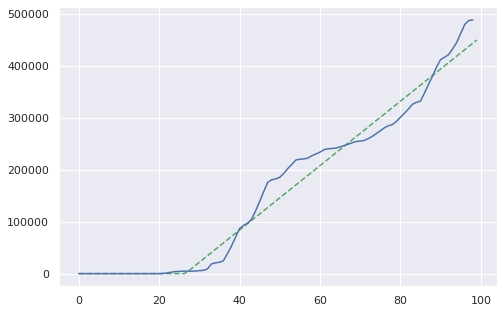

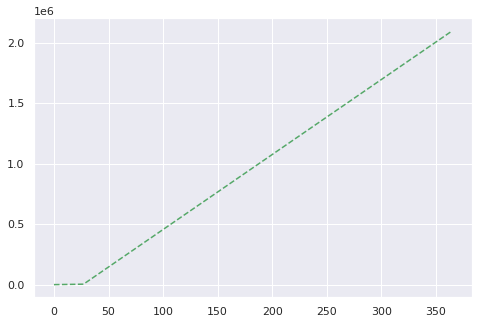

In [81]:
# Vaccines
print(aut_vac['Vaccinated_full'])
print(aut_vac.loc[aut_vac['Vaccinated_full'] != 0])
vac = aut_vac['Vaccinated_full'].to_numpy()
# plt.plot(aut_vac['Vaccinated_full'].to_numpy())

# Start Date is 2020-12-27, 307 days after start of pandemic in Austria on 25.02.2020

# Next we fit a 4th degree polynomial to the vaccinations curve using least squares method
# so we can estimate future vaccinations progress.

#poly4 = lambda x, a, b, c, d, e: a*(x**4) + b*(x**3) + c*(x**2) + d*(x**2) + e
#def func(x, a, b, c, d, e):
#    y = poly4(x, a, b, c, d, e)
#    return np.abs(y*(y>0))
    
#poly3 = lambda x, a, b, c, d: a*(x**3) + b*(x**2) + c*(x**1) + d*(x**0) 
#def func(x, a, b, c, d):
#    y = poly3(x, a, b, c, d)
#    return np.abs(y*(y>0))

#poly2 = lambda x, a, b, c: a*(x**2) + b*(x**1) + c*(x**0)
#def func(x, a, b, c):
#    y = poly2(x, a, b, c)
#    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def func(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))
    
    

xdata = np.linspace(0,1,len(vac))*len(vac)
popt, pcov = curve_fit(func, xdata, vac, method='lm')

# Check quality of fit with R2
print(r2_score(func(xdata, *popt), vac))
plt.plot(xdata, func(xdata, *popt), 'g--')
plt.plot(aut_vac['Vaccinated_full'].to_numpy())
plt.show()

# Predict a whole year of vaccinations and see how it looks like:
dur = 365
xdata = np.linspace(0,1,dur)*dur
plt.plot(xdata, func(xdata, *popt), 'g--')
plt.show()

In [82]:
# Effective reproduction number, etc AGES
# https://www.ages.at/en/wissen-aktuell/publikationen/epidemiologische-parameter-des-covid19-ausbruchs-oesterreich-20202021/

urls = ['https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/growth.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff_bundesland.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/meta_data.csv'
    ]

for url in urls:
    with open('./data/ages/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())

aut_reff = pd.read_csv("./data/ages/R_eff.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} ) 
aut_reff[0:]=aut_reff[0:].replace({',' : '.'}, regex=True).astype(float)
print(aut_reff.head())

               R_eff  R_eff_lwr  R_eff_upr
Datum                                     
2020-03-10  2.724623   2.364393   3.110021
2020-03-11  3.158794   2.817445   3.519379
2020-03-12  3.073370   2.781653   3.379425
2020-03-13  3.266824   3.007643   3.536563
2020-03-14  3.214620   2.994746   3.442174


Int64Index([202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010,
            202011, 202012, 202101, 202102],
           dtype='int64', name='REF_DATE')
Index(['NUTS1', 'NUTS2', 'NUTS3', 'DISTRICT_CODE', 'SUB_DISTRICT_CODE', 'T',
       'T_MAX', 'T_MIN', 'MEAN_T_MAX', 'MEAN_T_MIN', 'NUM_FROST', 'NUM_ICE',
       'NUM_SUMMER', 'NUM_HEAT', 'P', 'P_MAX', 'P_MIN', 'SUN_H', 'NUM_CLEAR',
       'NUM_CLOUD', 'REL_HUM', 'REL_HUM_MAX', 'REL_HUM_MIN', 'WIND_VEL',
       'NUM_WIND_VEL60', 'WIND_VEL_MAX', 'PRECP_SUM', 'NUM_PRECP_01',
       'STAT_NUM', 'Unnamed: 30', 'Unnamed: 31'],
      dtype='object')


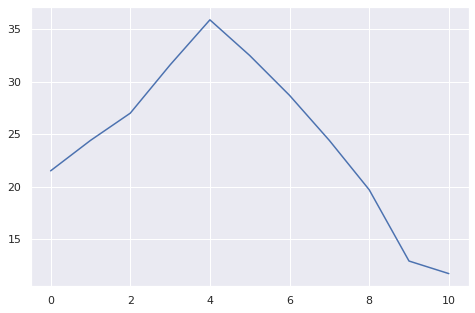

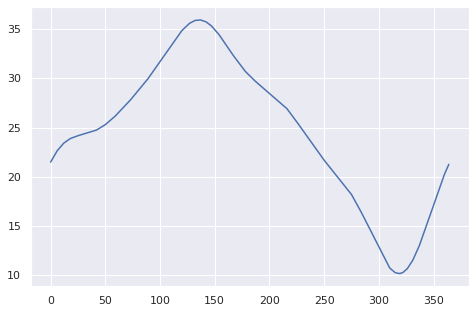

In [83]:
# Some papers suggest association between temperatures and virus spread
# https://repositum.tuwien.at/bitstream/20.500.12708/17056/1/Prager%20Lukas%20-%202021%20-%20Examining%20Austrian%20COVID-19%20Data%20in%20the%20Context%20of%20Linear...pdf#%5B%7B%22num%22%3A1106%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C72%2C628.0339966%2Cnull%5D
# https://www.sciencedirect.com/science/article/pii/S0048969720379213
# https://www.sciencedirect.com/science/article/pii/S1201971220302848

url = 'https://www.wien.gv.at/gogv/l9ogdwetter'
with open('./data/wiengv/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())
            
aut_weather= pd.read_csv("./data/wiengv/l9ogdwetter", sep=';', index_col = 0, header = 1)
aut_weather[aut_weather.columns[5:29]] = aut_weather[aut_weather.columns[5:29]].replace({',' : '.'}, regex=True).astype(float)
print(aut_weather.index[782:]) #which rows to select for data since march 1 2020
print(aut_weather.columns)
X_w = aut_weather[aut_weather.columns[6]].iloc[782:782+11]
plt.plot(X_w.to_numpy())
plt.show()
X_w = signal.resample(X_w, aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])
plt.plot(X_w)
plt.show()

## Regression analysis of variables

In [84]:
# Remove Colinear Variables
# https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
# https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html   

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = []
        for ix in range(X.iloc[:, variables].shape[1]):
            try:
                vif_ix = variance_inflation_factor(X.iloc[:, variables].values, ix)
                vif.append(vif_ix)
            except:
                vif.append(thresh+1.0)

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

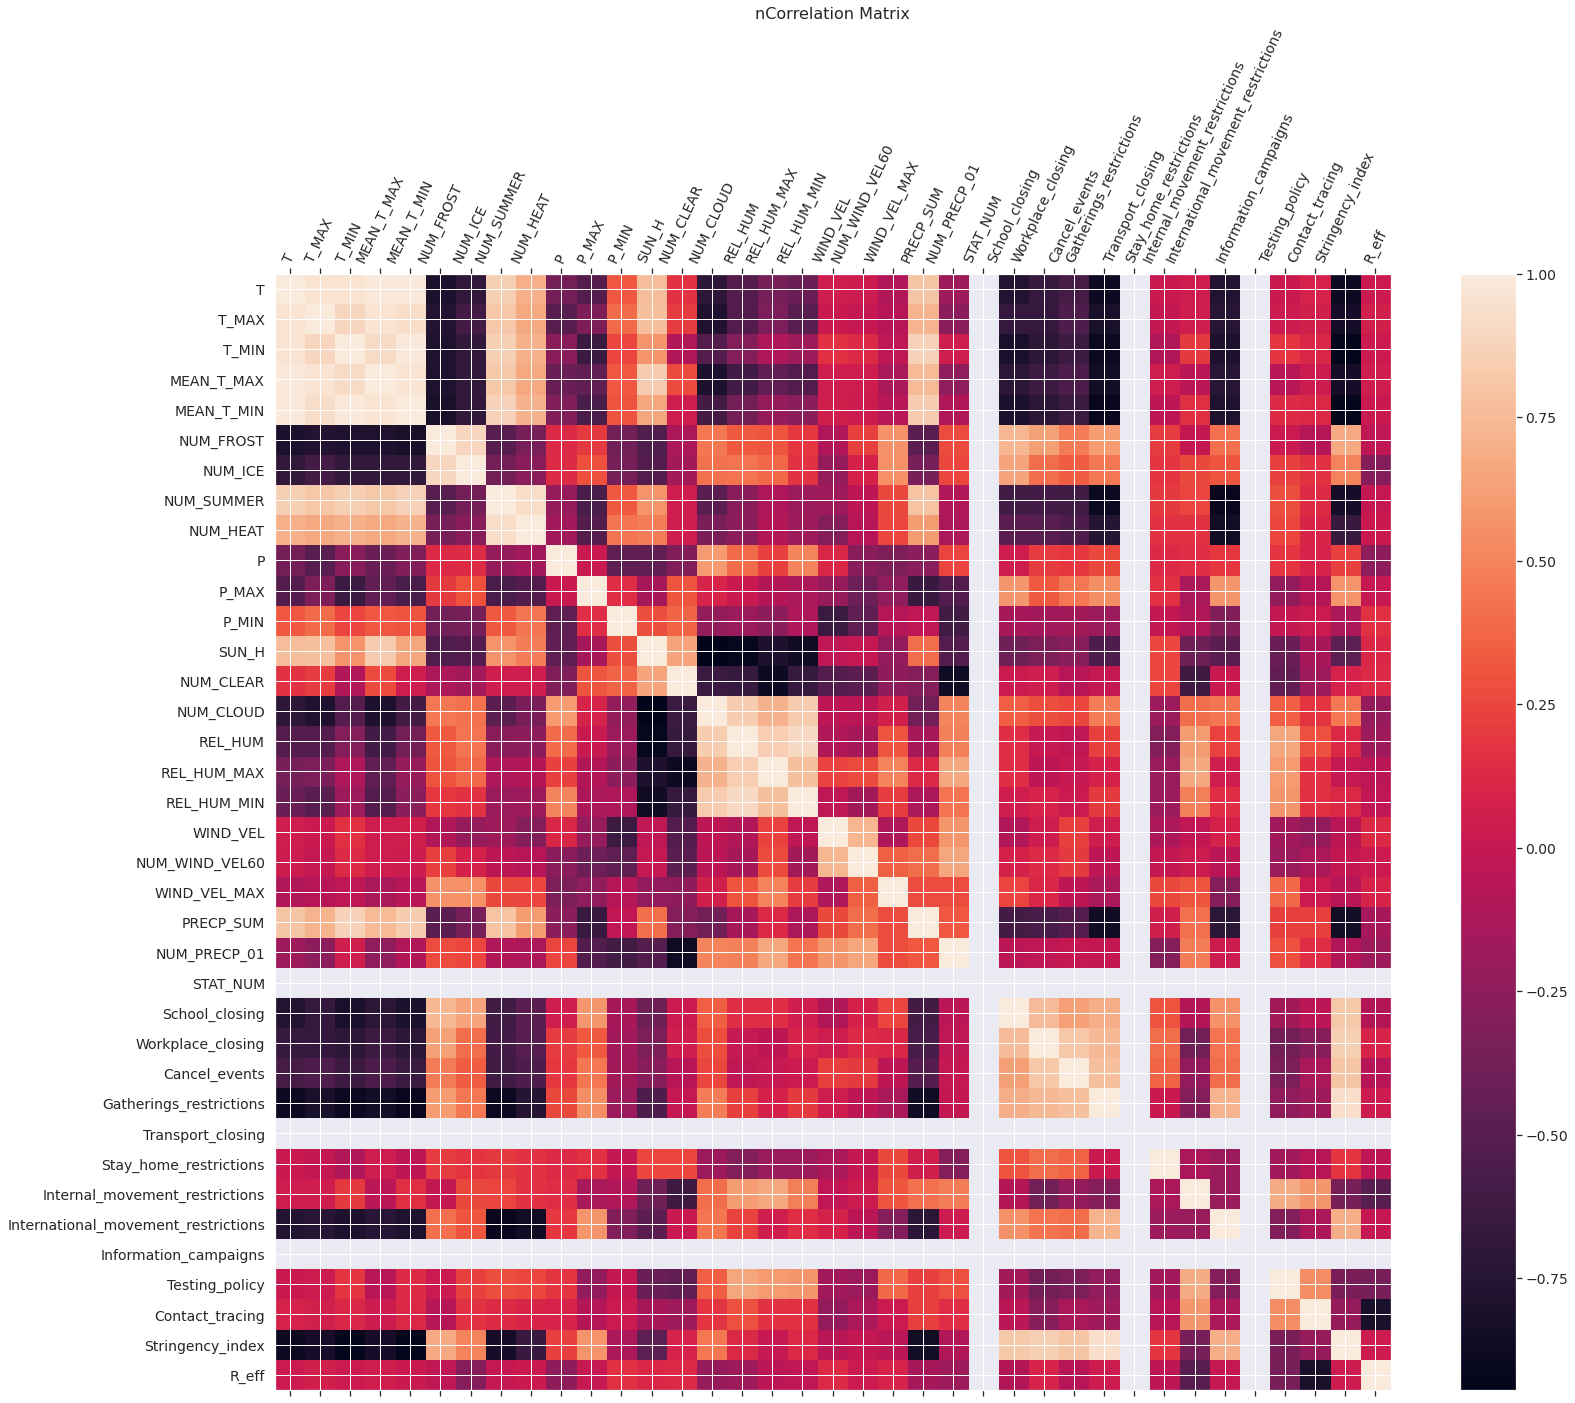

dropping 'T' at index: 0
dropping 'T_MAX' at index: 0
dropping 'T_MIN' at index: 0
dropping 'MEAN_T_MAX' at index: 0
dropping 'MEAN_T_MIN' at index: 0
dropping 'NUM_FROST' at index: 0
dropping 'NUM_ICE' at index: 0
dropping 'NUM_SUMMER' at index: 0
dropping 'NUM_HEAT' at index: 0
dropping 'P' at index: 0
dropping 'P_MAX' at index: 0
dropping 'P_MIN' at index: 0
dropping 'STAT_NUM' at index: 11
dropping 'REL_HUM_MAX' at index: 4
dropping 'REL_HUM' at index: 3
dropping 'WIND_VEL' at index: 4
dropping 'WIND_VEL_MAX' at index: 5
dropping 'NUM_PRECP_01' at index: 6
dropping 'REL_HUM_MIN' at index: 3
dropping 'SUN_H' at index: 0
dropping 'NUM_WIND_VEL60' at index: 2
Remaining variables:
Index(['NUM_CLEAR', 'NUM_CLOUD', 'PRECP_SUM'], dtype='object')

 All Featres OLS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                

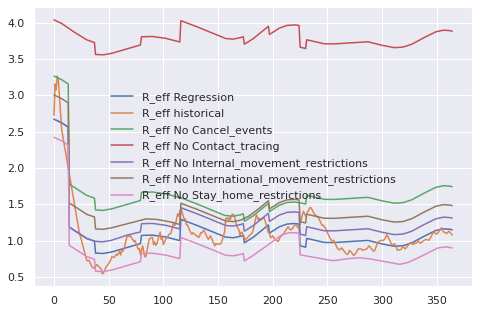

"\n# Do F/t-tests on gov and weather regression coefficients to judge their statistical significance\nmod = sm.OLS(y, X_g)\nres = mod.fit()\nx = np.linspace(0,365, 365)\nprint('\n Gov. only')\nprint(res.summary())\n\nmod = sm.OLS(y, X_w)\nres = mod.fit()\nx = np.linspace(0,365, 365)\nprint('\n Weather. only')\nprint(res.summary())\n\n# Merge featrues\nX = pd.concat((X_w, X_g), axis=1)\n#print(X.shape)\n\n#Scaling and Regression on all featrues\nsc_X = StandardScaler()\nX_sc = sc_X.fit_transform(X)\nreg = LinearRegression().fit(X_sc, y)\nprint(reg.score(X_sc,y)) #R2 Score\n\nX_sc = pd.DataFrame(X_sc, columns=X.columns)\nX_sc = calculate_vif_(X_sc, thresh=1)\nprint(X_sc.columns)\nX_sc = sc_X.fit_transform(X)\nreg = LinearRegression().fit(X_sc, y)\nprint(reg.score(X_sc,y)) #R2 Score\n\n# Select the overall K best features based on Univariate Linear regression Regression and F-testing\n# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html\n# Get fe

In [231]:
# Regression analysis
# Goodness of fit --> R2
# Significance F-Test overall, t-tests individual params.

# Effective reproduction number
y = aut_reff['R_eff'].iloc[0:365].to_numpy()

# Gov. measures
X_g = aut_gov[75:(75+365)][aut_gov.columns[1:]].reset_index(drop=True) #15 march
      
# Weather
X_w = aut_weather.iloc[782:][aut_weather.columns[5:29]]
X_w = signal.resample(X_w, y.shape[0])
X_w = pd.DataFrame(X_w, columns = aut_weather.columns[5:29])

# Merge
X = pd.concat((X_w, X_g), axis=1)

# Explore X,y data visually
Xy = pd.concat((X, pd.DataFrame(y, columns=['R_eff'])), axis=1)
Xy.reset_index(drop=True, inplace=True)

f = plt.figure(figsize=(25, 20))
plt.matshow(Xy.corr(), fignum=f.number)
plt.xticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14, rotation=65)
plt.yticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('nCorrelation Matrix', fontsize=16);
plt.show()

# Remove multicolinearity from weather data, merge again
X_w = calculate_vif_(X_w, thresh=5) # 
X = pd.concat((X_w, X_g), axis=1)

# Evaluate OLS model on all features via F/t-testing
# Interpretation
# https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01
# https://medium.com/analytics-vidhya/how-to-interpret-result-from-linear-regression-3f7ae7679ef9
# https://de.wikipedia.org/wiki/Testen_allgemeiner_linearer_Hypothesen#Einzelgleichungsmodell
# https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
# https://en.wikipedia.org/wiki/Regression_analysis
mod = sm.OLS(y, X)
res = mod.fit()
x = np.linspace(0,365, 365)
print('\n All Featres OLS')
print(res.summary())

# Remove statistically insignificant (p 0.05) features, they could break the model
# :
insignificant = ['School_closing', 'Workplace_closing', 'Gatherings_restrictions', 
             'Testing_policy', 'Stringency_index']

X = X.drop(columns=insignificant)

#Evaluate OLS again
mod = sm.OLS(y, X)
res = mod.fit()
x = np.linspace(0,365, 365)
print('\n Selected Featres OLS')
print(res.summary())

# Still some multicolinearity but we need some restriction to remove
# Let's test the model an see how it behaves:

plt.plot(res.predict(X), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
plt.plot(res.predict(X.assign(Cancel_events = 0)), label = 'R_eff No Cancel_events')
plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0)), label = 'R_eff No International_movement_restrictions')
plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
#plt.plot(res.predict(X.assign(Transport_closing = 0)), label = 'R_eff No Transport_closing')
#plt.plot(res.predict(X.assign(Information_campaigns = 0)), label = 'R_eff No Information_campaigns')
plt.legend()
plt.show()


'''
# Do F/t-tests on gov and weather regression coefficients to judge their statistical significance
mod = sm.OLS(y, X_g)
res = mod.fit()
x = np.linspace(0,365, 365)
print('\n Gov. only')
print(res.summary())

mod = sm.OLS(y, X_w)
res = mod.fit()
x = np.linspace(0,365, 365)
print('\n Weather. only')
print(res.summary())

# Merge featrues
X = pd.concat((X_w, X_g), axis=1)
#print(X.shape)

#Scaling and Regression on all featrues
sc_X = StandardScaler()
X_sc = sc_X.fit_transform(X)
reg = LinearRegression().fit(X_sc, y)
print(reg.score(X_sc,y)) #R2 Score

X_sc = pd.DataFrame(X_sc, columns=X.columns)
X_sc = calculate_vif_(X_sc, thresh=1)
print(X_sc.columns)
X_sc = sc_X.fit_transform(X)
reg = LinearRegression().fit(X_sc, y)
print(reg.score(X_sc,y)) #R2 Score

# Select the overall K best features based on Univariate Linear regression Regression and F-testing
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html
# Get feature names:
# https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le
select_k = 10
selector = SelectKBest(score_func=f_regression, k=select_k)
X_best = selector.fit_transform(X_sc, y)
mask = selector.get_support() #list of booleans
f_reg_features = [] # The list of your K best features
for bool, feature in zip(mask, X.columns):
    if bool:
        f_reg_features.append(feature)
print('\nSelected k Reg. Features:', f_reg_features)

#Repeat with mutual information
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression
selector = SelectKBest(score_func=mutual_info_regression, k=select_k)
X_best = selector.fit_transform(X_sc, y)
mask = selector.get_support() #list of booleans
mi_features = [] # The list of your K best features
for bool, feature in zip(mask, X.columns):
    if bool:
        mi_features.append(feature)
print('Selected k MI Features:', mi_features)

# Do F/t-tests on selected features to judge their statistical significance
mod = sm.OLS(y, X[mi_features])
res = mod.fit()
x = np.linspace(0,365, 365)
# Interpretation
# https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01
# https://medium.com/analytics-vidhya/how-to-interpret-result-from-linear-regression-3f7ae7679ef9
# https://de.wikipedia.org/wiki/Testen_allgemeiner_linearer_Hypothesen#Einzelgleichungsmodell
# https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
print('\nMI Features Testing')
print(res.summary())

mod = sm.OLS(y, X[f_reg_features])
res = mod.fit()
x = np.linspace(0,365, 365)
print('\nReg. Features Testing')
print(res.summary())
'''

## SIR Model

(397,) (397,) (397,)


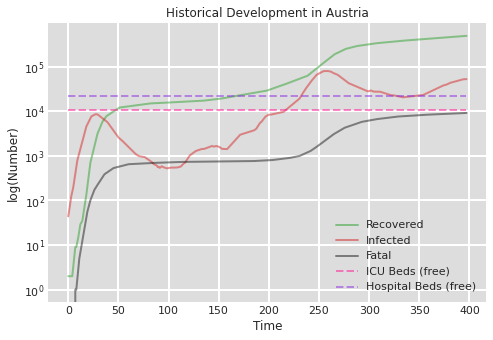

In [214]:
ICUs_free = 10720 # Mar 27 2020
HOSPs_free = 21682 # Mar 27 2020

#Historical Development
infected = aut_cov['Infected'].to_numpy()
fatal = aut_cov['Fatal'].to_numpy()
recovered = aut_cov['Recovered'].to_numpy()
print(infected.shape, fatal.shape, recovered.shape)

duration = len(aut_cov['Infected'].to_numpy())
t = np.linspace(0, duration, duration)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, recovered, 'tab:green', alpha=0.5, lw=2, label='Recovered')
ax.plot(t, infected, 'tab:red', alpha=0.5, lw=2, label='Infected')
ax.plot(t, fatal, 'k', alpha=0.5, lw=2, label='Fatal')
ax.plot(t, [ICUs_free]*len(fatal),'deeppink', alpha=0.5, lw=2, label='ICU Beds (free)' , linestyle='dashed')
ax.plot(t, [HOSPs_free]*len(fatal), 'blueviolet', alpha=0.5, lw=2, label='Hospital Beds (free)', linestyle='dashed')
ax.set_xlabel('Time')
ax.set_ylabel('log(Number)')
ax.set_yscale('log')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("Historical Development in Austria")
plt.show()

In [215]:
# SIR disease model
# Source: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# Modified it for fatalities myself.

# http://sherrytowers.com/2012/12/11/sir-model-with-age-classes/
# ICUs
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
ICUs_free = 1072 # Mar 27 2020
HOSPs_free = 21682 # Mar 27 2020
VAC_effect = 0.7 #Probability of any vaccine preventing disease

def deriv(y, t, N, beta, gamma, delta, epsilon, rho, func, popt, t_vac_start):
    y_i = ()
    ICUs_required = 0
    HOSPs_requried = 0
    #Compute ICUs and Hospital Beds required
    N_sum = sum(N)
    def get_vaxed(t, N_sum):
        V = 0
        if t >= t_vac_start:
            V = func(t-t_vac_start, *popt)
            if V > N_sum: V = N_sum
            if V < 0: V = 0
        return V
    
    for i in range(0,len(y),5):
        S, I, R, F, V = y[i:i+5]
        ICUs_required+=I*epsilon[i//5]*rho[i//5]
        HOSPs_requried+=I*epsilon[i//5]*rho[i//5]
    HOSPs_requried - ICUs_required
    omega = float(ICUs_required > ICUs_free)
    kappa = float(HOSPs_requried > HOSPs_free)
    
    N_vaxed = get_vaxed(t, N_sum) 
    p_vaxed = N_vaxed/N_sum # probability any person in the population is fully vaxed

    for i in range(0,len(y),5):
        S, I, R, F, V = y[i:i+5]
        dVdt = S*p_vaxed*VAC_effect
        if S > 0:
            dSdt = -beta[i//5] * S * I / N[i//5] - dVdt
        else: 
            dSdt = +0.0
        dRdt = I * gamma[i//5] * (1 - (epsilon[i//5]*rho[i//5]*omega + rho[i//5]*kappa))
        dFdt = I * delta[i//5] * (1 + epsilon[i//5]*rho[i//5]*omega + rho[i//5]*kappa)
        dIdt = beta[i//5]  * S * I / N[i//5]  - dRdt - dFdt
        y_i += dSdt, dIdt, dRdt, dFdt, dVdt
    return y_i

def run_sim(N, I0, R0, F0, V0, beta, gamma, delta, epsilon, rho, t, deriv, func, popt, t_vac_start):
    #Make y0:
    y0 = ()
    for n in N:
        S0 = n - I0 - R0
        y0 += (S0, I0, R0, F0, V0)
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, epsilon, rho, func, popt, t_vac_start))
    return [*ret.T]

8901064.0
204845.3018275475 196705.10468448923


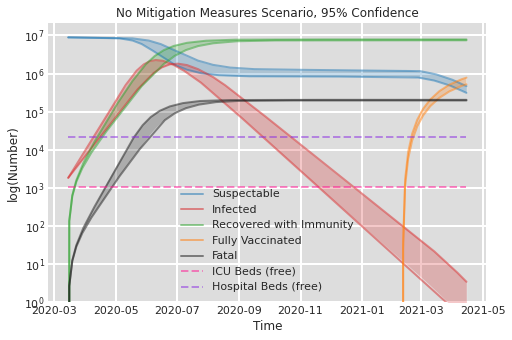

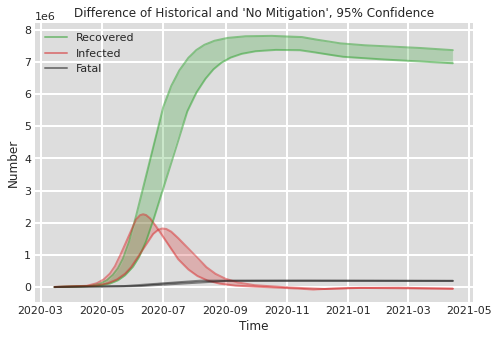

In [216]:
# Scenario 1: Pandemic Ignored
# We assume the maximum Reproduction number (Confidence 0.95) observed in Austria during any time period.
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich

duration = len(aut_cov['Infected'].to_numpy())
t = np.linspace(0, duration, duration)
t_vac_start = 307

# Set Params
R_base = 2.4 #Base reproduction number
I0, R0, F0, V0 = 205, 0, 0, 0 #205 Covid Cases March 15 2020
delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
gamma = [((1.-x)/14) for x in pop_groups_ifr] #Recovery without Death after 14 Days
epsilon = pop_groups_hosp_icu
rho = pop_groups_hosp
beta = [R_base*(gamma[i]+d)for i, d in enumerate(delta)]
ret = run_sim(pop_groups, I0, R0, F0, V0, beta, gamma, delta, epsilon, rho, t, deriv, func, popt, t_vac_start)
S, I, R, F, V = 0, 0, 0, 0, 0
for i in range(0,len(ret),5):
    S+=ret[i]
    I+=ret[i+1]
    R+=ret[i+2]
    F+=ret[i+3]
    V+=ret[i+4]

R_base = 2.1
beta = [R_base*(gamma[i]+d)for i, d in enumerate(delta)]
ret1 = run_sim(pop_groups, I0, R0, F0, V0, beta, gamma, delta, epsilon, rho, t, deriv, func, popt, t_vac_start)
S1, I1, R1, F1, V1 = 0, 0, 0, 0, 0
for i in range(0,len(ret1),5):
    S1+=ret1[i]
    I1+=ret1[i+1]
    R1+=ret1[i+2]
    F1+=ret1[i+3]
    V1+=ret1[i+4]

print(F[-1]+R[-1]+S[-1]+I[-1]+V[-1])
print(F[-1], F1[-1])

#Fancyplot
# Plot the data on three separate curves for S(t), I(t) and R(t), F(t)
base = datetime.datetime(2020, 3, 15, 00, 00)
t = [base + datetime.timedelta(days=x) for x in range(duration)]
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.plot(t, S, 'tab:blue', alpha=0.5, lw=2, label='Suspectable')
ax.plot(t, S1, 'tab:blue', alpha=0.5, lw=2)
ax.plot(t, I, 'tab:red', alpha=0.5, lw=2, label='Infected')
ax.plot(t, I1, 'tab:red', alpha=0.5, lw=2)
ax.plot(t, R, 'tab:green', alpha=0.5, lw=2, label='Recovered with Immunity')
ax.plot(t, R1, 'tab:green', alpha=0.5, lw=2)
ax.plot(t, V, 'tab:orange', alpha=0.5, lw=2, label='Fully Vaccinated')
ax.plot(t, V1, 'tab:orange', alpha=0.5, lw=2)
ax.plot(t, F, 'k', alpha=0.5, lw=2, label='Fatal')
ax.plot(t, F1, 'k', alpha=0.5, lw=2)
ax.fill_between(t, S1, S, facecolor='tab:blue', alpha=0.25, interpolate=True)
ax.fill_between(t, R1, R, facecolor='tab:green', alpha=0.25, interpolate=True)
ax.fill_between(t, I1, I, facecolor='tab:red', alpha=0.25, interpolate=True)
ax.fill_between(t, V1, V, facecolor='tab:orange', alpha=0.25, interpolate=True)
ax.fill_between(t, F1, F, facecolor='k', alpha=0.25, interpolate=True)
ax.plot(t, [ICUs_free]*len(F),'deeppink', alpha=0.5, lw=2, label='ICU Beds (free)' , linestyle='dashed')
ax.plot(t, [HOSPs_free]*len(F), 'blueviolet', alpha=0.5, lw=2, label='Hospital Beds (free)', linestyle='dashed')
#ax.axvline(x=365*51.0403, ymin=0, ymax=1, label='First Fully Vaccinated Person')
ax.set_xlabel('Time')
ax.set_ylabel('log(Number)')
ax.set_yscale('log')
ax.set_ylim(1.0)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("No Mitigation Measures Scenario, 95% Confidence")
plt.show()


# Lets look at the difference to the historical pandemic
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, R-recovered, 'tab:green', alpha=0.5, lw=2, label='Recovered')
ax.plot(t, I-infected, 'tab:red', alpha=0.5, lw=2, label='Infected')
ax.plot(t, F-fatal, 'k', alpha=0.5, lw=2, label='Fatal')
ax.plot(t, R1-recovered, 'tab:green', alpha=0.5, lw=2)
ax.plot(t, I1-infected, 'tab:red', alpha=0.5, lw=2)
ax.plot(t, F1-fatal, 'k', alpha=0.5, lw=2)

ax.fill_between(t, F1-fatal, F-fatal, facecolor='k', alpha=0.25, interpolate=True)
ax.fill_between(t, I1-infected, I-infected, facecolor='tab:red', alpha=0.25, interpolate=True)
ax.fill_between(t, R1-recovered, R-recovered, facecolor='tab:green', alpha=0.25, interpolate=True)

ax.set_xlabel('Time')
ax.set_ylabel('Number')
#ax.set_yscale('log')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("Difference of Historical and 'No Mitigation', 95% Confidence")
plt.show()


1.070625 1.1881250000000003
8901064.0
32519.196512981678 2626.766270746497


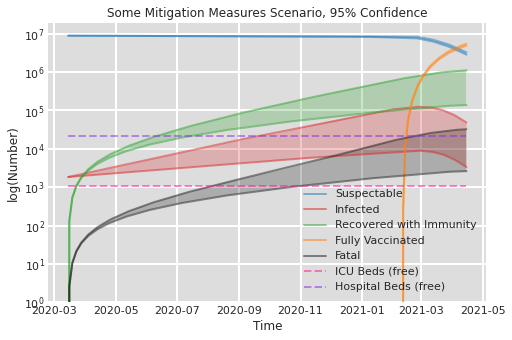

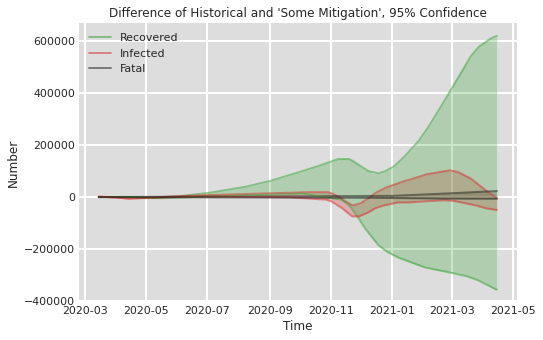

In [217]:
# Scenario 2: Some Mitigation Measures (such as we had in Summer) starting on March 15 and kept for whole pandemic
# We assume the averge Reproduction number (Confidence 0.95) observed in Austria during
# 31.05 - 30.09 time period
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich
R_base_l = [0.86,0.95,1.0,1.27,1.22,1.04,1.05,0.96,0.91,1.26,1.1,0.99,1.21,1.27,1.07,0.97]
R_base_l = sum(R_base_l)/len(R_base_l)
R_base_h = [1.06,1.15,1.21,1.48,1.37,1.16,1.17,1.06,1.01,1.36,1.18,1.06,1.28,1.33,1.12,1.01]
R_base_h = sum(R_base_h)/len(R_base_h)
print(R_base_l, R_base_h)

duration = len(aut_cov['Infected'].to_numpy())
t = np.linspace(0, duration, duration)
t_vac_start = 307

# Set Params
R_base = R_base_h #Base reproduction number
I0, R0, F0, V0 = 205, 0, 0, 0
delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
gamma = [((1.-x)/14) for x in pop_groups_ifr] #Recovery without Death after 14 Days
epsilon = pop_groups_hosp_icu
rho = pop_groups_hosp
beta = [R_base*(gamma[i]+d)for i, d in enumerate(delta)]
ret = run_sim(pop_groups, I0, R0, F0, V0, beta, gamma, delta, epsilon, rho, t, deriv, func, popt, t_vac_start)
S, I, R, F, V = 0, 0, 0, 0, 0
for i in range(0,len(ret),5):
    S+=ret[i]
    I+=ret[i+1]
    R+=ret[i+2]
    F+=ret[i+3]
    V+=ret[i+4]

R_base = R_base_l
beta = [R_base*(gamma[i]+d)for i, d in enumerate(delta)]
ret1 = run_sim(pop_groups, I0, R0, F0, V0, beta, gamma, delta, epsilon, rho, t, deriv, func, popt, t_vac_start)
S1, I1, R1, F1, V1 = 0, 0, 0, 0, 0
for i in range(0,len(ret1),5):
    S1+=ret1[i]
    I1+=ret1[i+1]
    R1+=ret1[i+2]
    F1+=ret1[i+3]
    V1+=ret1[i+4]

print(F[-1]+R[-1]+S[-1]+I[-1]+V[-1])
print(F[-1], F1[-1])

#Fancyplot
# Plot the data on three separate curves for S(t), I(t) and R(t), F(t)
base = datetime.datetime(2020, 3, 15, 00, 00)
t = [base + datetime.timedelta(days=x) for x in range(duration)]
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.plot(t, S, 'tab:blue', alpha=0.5, lw=2, label='Suspectable')
ax.plot(t, S1, 'tab:blue', alpha=0.5, lw=2)
ax.plot(t, I, 'tab:red', alpha=0.5, lw=2, label='Infected')
ax.plot(t, I1, 'tab:red', alpha=0.5, lw=2)
ax.plot(t, R, 'tab:green', alpha=0.5, lw=2, label='Recovered with Immunity')
ax.plot(t, R1, 'tab:green', alpha=0.5, lw=2)
ax.plot(t, V, 'tab:orange', alpha=0.5, lw=2, label='Fully Vaccinated')
ax.plot(t, V1, 'tab:orange', alpha=0.5, lw=2)
ax.plot(t, F, 'k', alpha=0.5, lw=2, label='Fatal')
ax.plot(t, F1, 'k', alpha=0.5, lw=2)
ax.fill_between(t, S1, S, facecolor='tab:blue', alpha=0.25, interpolate=True)
ax.fill_between(t, R1, R, facecolor='tab:green', alpha=0.25, interpolate=True)
ax.fill_between(t, I1, I, facecolor='tab:red', alpha=0.25, interpolate=True)
ax.fill_between(t, V1, V, facecolor='tab:orange', alpha=0.25, interpolate=True)
ax.fill_between(t, F1, F, facecolor='k', alpha=0.25, interpolate=True)
ax.plot(t, [ICUs_free]*len(F),'deeppink', alpha=0.5, lw=2, label='ICU Beds (free)' , linestyle='dashed')
ax.plot(t, [HOSPs_free]*len(F), 'blueviolet', alpha=0.5, lw=2, label='Hospital Beds (free)', linestyle='dashed')
#ax.axvline(x=365*51.0403, ymin=0, ymax=1, label='First Fully Vaccinated Person')
ax.set_xlabel('Time')
ax.set_ylabel('log(Number)')
ax.set_yscale('log')
ax.set_ylim(1.0)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("Some Mitigation Measures Scenario, 95% Confidence")
plt.show()

# Lets look at the difference to the historical pandemic

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, R-recovered, 'tab:green', alpha=0.5, lw=2, label='Recovered')
ax.plot(t, I-infected, 'tab:red', alpha=0.5, lw=2, label='Infected')
ax.plot(t, F-fatal, 'k', alpha=0.5, lw=2, label='Fatal')
ax.plot(t, R1-recovered, 'tab:green', alpha=0.5, lw=2)
ax.plot(t, I1-infected, 'tab:red', alpha=0.5, lw=2)
ax.plot(t, F1-fatal, 'k', alpha=0.5, lw=2)

ax.fill_between(t, F1-fatal, F-fatal, facecolor='k', alpha=0.25, interpolate=True)
ax.fill_between(t, I1-infected, I-infected, facecolor='tab:red', alpha=0.25, interpolate=True)
ax.fill_between(t, R1-recovered, R-recovered, facecolor='tab:green', alpha=0.25, interpolate=True)

ax.set_xlabel('Time')
ax.set_ylabel('Number')
#ax.set_yscale('log')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("Difference of Historical and 'Some Mitigation', 95% Confidence")
plt.show()

## Improved SIR Model taking weather into account

In [218]:
# SIR disease model
# Source: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# Modified it for fatalities myself.

# http://sherrytowers.com/2012/12/11/sir-model-with-age-classes/
# ICUs
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
ICUs_free = 1072 # Mar 27 2020
HOSPs_free = 21682 # Mar 27 2020
VAC_effect = 0.7 #Probability of any vaccine preventing disease

def deriv(y, t, N, beta, gamma, delta, epsilon, rho, func, popt, t_vac_start, R_eff):
    y_i = ()
    ICUs_required = 0
    HOSPs_requried = 0
    #Compute ICUs and Hospital Beds required
    N_sum = sum(N)
    def get_vaxed(t, N_sum):
        V = 0
        if t >= t_vac_start:
            V = func(t-t_vac_start, *popt)
            if V > N_sum: V = N_sum
            if V < 0: V = 0
        return V
    
    for i in range(0,len(y),5):
        S, I, R, F, V = y[i:i+5]
        ICUs_required+=I*epsilon[i//5]*rho[i//5]
        HOSPs_requried+=I*epsilon[i//5]*rho[i//5]
    HOSPs_requried - ICUs_required
    omega = float(ICUs_required > ICUs_free)
    kappa = float(HOSPs_requried > HOSPs_free)
    
    N_vaxed = get_vaxed(t, N_sum) 
    p_vaxed = N_vaxed/N_sum # probability any person in the population is fully vaxed

    beta = [R_eff[int(t)]*(gamma[i]+d)for i, d in enumerate(delta)]
    
    for i in range(0,len(y),5):
        S, I, R, F, V = y[i:i+5]
        dVdt = S*p_vaxed*VAC_effect
        if S > 0:
            dSdt = -beta[i//5] * S * I / N[i//5] - dVdt
        else: 
            dSdt = +0.0
        dRdt = I * gamma[i//5] * (1 - (epsilon[i//5]*rho[i//5]*omega + rho[i//5]*kappa))
        dFdt = I * delta[i//5] * (1 + epsilon[i//5]*rho[i//5]*omega + rho[i//5]*kappa)
        dIdt = beta[i//5]  * S * I / N[i//5]  - dRdt - dFdt
        y_i += dSdt, dIdt, dRdt, dFdt, dVdt
    return y_i

def run_sim(N, I0, R0, F0, V0, beta, gamma, delta, epsilon, rho, t, deriv, func, popt, t_vac_start, R):
    #Make y0:
    y0 = ()
    for n in N:
        S0 = n - I0 - R0
        y0 += (S0, I0, R0, F0, V0)
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, epsilon, rho, func, popt, t_vac_start, R))
    return [*ret.T]

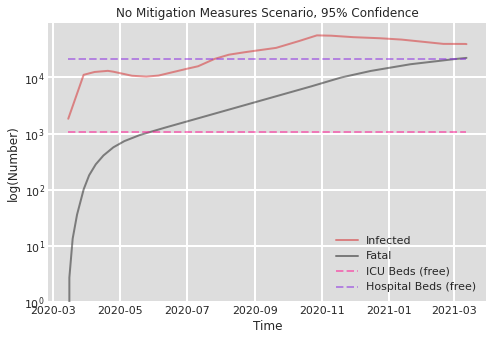

8901064.000000048
22324.200256914006


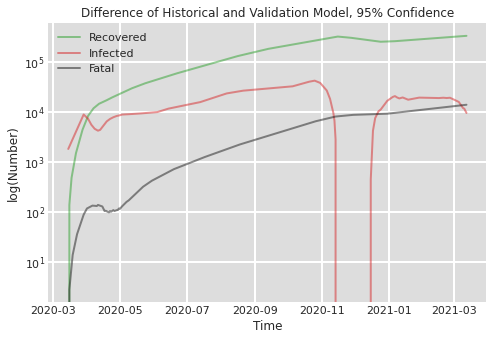

In [219]:
# Scenario 0: Validate model with histroical data
# Scenario 1: Pandemic Ignored
# We assume the maximum Reproduction number (Confidence 0.95) observed in Austria during any time period.
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich

duration = 363#len(aut_cov['Infected'].to_numpy())
t = np.linspace(0, duration, duration)
t_vac_start = 307

# Set Params
#R_eff = y
#R_eff = res.predict(X.assign(Cancel_events = 0))
#R_eff = res.predict(X.assign(Contact_tracing = 0))
#R_eff = res.predict(X.assign(Internal_movement_restrictions = 0))
#R_eff = res.predict(X.assign(International_movement_restrictions = 0))
R_eff = res.predict(X)
I0, R0, F0, V0 = 205, 0, 0, 0 #205 Covid Cases March 15 2020
delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
gamma = [((1.-x)/14) for x in pop_groups_ifr] #Recovery without Death after 14 Days
epsilon = pop_groups_hosp_icu
rho = pop_groups_hosp
ret = run_sim(pop_groups, I0, R0, F0, V0, beta, gamma, delta, epsilon, rho, t, deriv, 
              func, popt, t_vac_start, R_eff)
S, I, R, F, V = 0, 0, 0, 0, 0
for i in range(0,len(ret),5):
    S+=ret[i]
    I+=ret[i+1]
    R+=ret[i+2]
    F+=ret[i+3]
    V+=ret[i+4]


#Fancyplot
# Plot the data on three separate curves for S(t), I(t) and R(t), F(t)
base = datetime.datetime(2020, 3, 15, 00, 00)
t = [base + datetime.timedelta(days=x) for x in range(duration)]
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
#ax.plot(t, S, 'tab:blue', alpha=0.5, lw=2, label='Suspectable')
ax.plot(t, I, 'tab:red', alpha=0.5, lw=2, label='Infected')
#ax.plot(t, R, 'tab:green', alpha=0.5, lw=2, label='Recovered with Immunity')
#ax.plot(t, V, 'tab:orange', alpha=0.5, lw=2, label='Fully Vaccinated')
ax.plot(t, F, 'k', alpha=0.5, lw=2, label='Fatal')
ax.plot(t, [ICUs_free]*len(F),'deeppink', alpha=0.5, lw=2, label='ICU Beds (free)' , linestyle='dashed')
ax.plot(t, [HOSPs_free]*len(F), 'blueviolet', alpha=0.5, lw=2, label='Hospital Beds (free)', linestyle='dashed')
#ax.axvline(x=365*51.0403, ymin=0, ymax=1, label='First Fully Vaccinated Person')
ax.set_xlabel('Time')
ax.set_ylabel('log(Number)')
ax.set_yscale('log')
ax.set_ylim(1.0)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("No Mitigation Measures Scenario, 95% Confidence")
plt.show()

print(F[-1]+R[-1]+S[-1]+I[-1]+V[-1])
print(F[-1])


# Lets look at the difference to the historical pandemic
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, R-recovered[:duration], 'tab:green', alpha=0.5, lw=2, label='Recovered')
ax.plot(t, I-infected[:duration], 'tab:red', alpha=0.5, lw=2, label='Infected')
ax.plot(t, F-fatal[:duration], 'k', alpha=0.5, lw=2, label='Fatal')
#ax.plot(t, recovered[:364], 'tab:green', alpha=0.5, lw=2)
#ax.plot(t, infected[:364], 'tab:red', alpha=0.5, lw=2)
#ax.plot(t, fatal[:364], 'k', alpha=0.5, lw=2)

#ax.fill_between(t, fatal[:364], F, facecolor='k', alpha=0.25, interpolate=True)
#ax.fill_between(t, infected[:364], I, facecolor='tab:red', alpha=0.25, interpolate=True)
#ax.fill_between(t, recovered[:364], R, facecolor='tab:green', alpha=0.25, interpolate=True)

ax.set_xlabel('Time')
ax.set_ylabel('log(Number)')
ax.set_yscale('log')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("Difference of Historical and Validation Model, 95% Confidence")
plt.show()
